In [6]:
import datajoint as dj
import pandas as pd
from datetime import date
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

# Establish connection 
dj.config['database.host'] = '34.82.94.188'
dj.config['database.user'] = 'yonib'
dj.config['database.password'] = 'yonib'
dj.conn()

# configure a schema for testing stuff
schema  = dj.schema('yonib_observatory_test',locals())

In [ ]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [7]:
@schema 
class Genotype(dj.Lookup):
    definition = """
    genotype:varchar(255)
    """
    contents = zip(['Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt'])

@schema
class SessionType(dj.Lookup):
    definition = """
    session_type:varchar(255)
    """
    contents = zip(['brain_observatory_1.1', 
                    'functional_connectivity'])


@schema
class Mouse(dj.Manual):
    definition = """
    # mouse information
    specimen_id: bigint  # unique mouse ID
    ---
    sex:enum('M','F','U') # Sex: Male, Female, Unkown
    -> Genotype
    """

# In my present formulation, things like channel and probe counts 
# and area ID can be found with queries but aren't included in the 
# Sessions table.
@schema
class Session(dj.Manual):
    definition = """
    ->Mouse
    session_id:bigint
    ---
    ->SessionType
    mouse_age:int # in days
    publication_date:date
    """
@schema
class ProbePhase(dj.Lookup):
    definition = """
    probe_phase:varchar(255)
    """
    contents = zip(['3a', 'PXI'])

    
@schema 
class Probe(dj.Manual):
    definition = """
    ->Session
    probe_id:bigint
    ---
    ->ProbePhase
    probe_name:varchar(10)
    """
@schema
class BrainStructure(dj.Lookup):
    definition = """
    structure:varchar(10)
    """
    contents = zip(['APN', 'BMAa', 'CA1', 'CA2', 'CA3', 'COAa', 'COApm', 'CP', 'DG',
       'Eth', 'HPF', 'IGL', 'IntG', 'LD', 'LGd', 'LGv', 'LP', 'LT', 'MB',
       'MGd', 'MGm', 'MGv', 'MRN', 'NOT', 'OLF', 'OP', 'PF', 'PIL', 'PO',
       'POL', 'POST', 'PP', 'PPT', 'PRE', 'PoT', 'ProS', 'RPF', 'RT',
       'SCig', 'SCiw', 'SCop', 'SCsg', 'SCzo', 'SGN', 'SUB', 'TH', 'VIS',
       'VISal', 'VISam', 'VISl', 'VISli', 'VISmma', 'VISmmp', 'VISp',
       'VISpm', 'VISrl', 'VL', 'VPL', 'VPM', 'ZI', 'grey', 'nan'])
    
@schema
class Channel(dj.Manual):
    definition = """
    ->Probe
    channel_id:bigint
    ---
    sampling_rate:float
    ->BrainStructure
    local_index:int
    probe_horizontal_position:int
    probe_vertial_position:int
    anterior_posterior_ccf_coordinate:float
    dorsal_ventral_ccf_coordinate:float
    left_right_ccf_coordinate:float
    """
    
@schema 
class Unit(dj.Manual):
    definition = """
    ->Channel
    #Metrics Go Here
    """
# I would prefer to have spiketrain data be part of the unit,
# But this is going to make more sense if we don't load all NWB files
@schema
class SpikeTrain(dj.Manual):
    definition = """
    ->Unit
    ---
    spike_ts:longblob
    """
    
@schema 
class LFP(dj.Manual):
    definition = """
    ->Channel
    ---
    lfp_sampling_rate:float
    lfp:longblob
    """
    


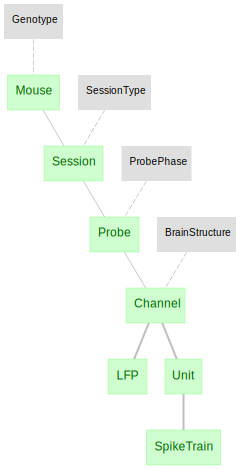

In [9]:
dj.ERD(schema)

In [10]:
# This notation is borrowed from the mesoscale folks. 
# I am assuming that it is best practices?
@schema
class SessionIngest(dj.Imported):
    definition = """
    session_filename:varchar(255)
    """
    
    def make(self,key):
        # For now, there is only one session file.
        self.insert1({'session_filename':
                      'C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\sessions.csv'})